<a href="https://colab.research.google.com/github/rileyseefeldt/ChessCNN/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Introduction

##1.1 Background and Context:

Convolutional Neural Networks are a cornerstone of modern deep learning systems, with their architecture often determining their performance in various tasks. However, the sensitivity of CNNs to specific architectural choices, particularly in structured decision-making tasks, remains an important and underexplored area.

Convolutional Neural Networks are a specific category of neural networks that excel in processing grid-like data through matrix computations. These networks contain several types of layers designed for processing structured data. These layers include:

1.  Convolutional Layer: Applies filters/kernels to an input matrix to extract specific features or patterns from the input.
2.  Activation Layer: Adds non linearity to the network through an activation function such as ReLU (Rectified Linear Unit) which allows the CNN to learn more complex patterns beyond simple linear mappings.
3.  Batch Normalization Layer: Normalizes the input of each layer to the activations of each layer in the network to prevent the distribution of input variables changing during the training process.
4.  Residual Connection: Skips over layers in the networks by directly adding the input of a layer to its output. This helps lessen the margin of error for networks with higher layers because it lets each layer only learn the difference (residual) between the input and desired output as opposed to forcing each layer to learn a new transformation.
5.  Fully Connected Layer: Connects every input node to every output node by flattening the extracted features. This means that each node in one layer is connected to all the nodes in the previous layers.
6.  Output Activation Layer: Applies final transformations to the output layer which provides an actionable output for the network.

Because CNNs revolve entirely around matrix computations, they are best suited for tasks which can be represented as a grid. Some of their use cases include image classification, computer vision, and board-game evaluation. The game of chess serves as the perfect testing ground for these systems because it is entirely deterministic and is still far from being completely solved, and it can be easily represented by an 8x8 matrix in a CNN.


##1.2 Research Problem:

While Convolutional Neural Networks are known to perform well across a variety of structural tasks, understanding the extent to which CNNs are affected by small architectural changes is important for optimizing these networks. Specific features such as the number of residual blocks and filters in the model are minor changes which have the potential to completely change the output of the network.

##1.3 Research Question:

How do small architectural changes in a CNN optimized for the game of chess, such as the number of residual blocks or filters, affect the accuracy and performance of the model overall?

##1.4 Research Contributions:

This project addresses several areas of AI research including (1) Deep Learning Architecture, (2) Structured Prediction, (3) Evaluation of AI systems:

1.  Deep Learning Architecture - research will study how specific model architecture affects the training process and accuracy of Convolutional Neural Networks. This can be useful in optimizing training parameters to find a mix of time/effectiveness for deep learning systems
2.  Structured Prediction - chess is a structured game with a finite number of moves/outcomes. Therefore this project will provide insight about the optimization of CNNs in structured prediction tasks (such as NLP or control tasks).
3.  Evaluation of AI systems - research will study how specific model architecture affects the measurable performance for CNNs. This can be particularly useful in fields like robotics or medicine where precision and reliability of performance are required


#2. Related Works

Similar projects about the use of convolutional neural networks in the game of chess have been explored before:

AlphaZero’s residual CNN architecture (Silver et al., 2017):

In 2017 a team at Deepmind created a general reinforcement learning algorithm that could be tailored to multiple games such as chess, shogi, and Go through self-training. It combines a deep CNN with a MCST to find optimal moves in these games at a level above humans. Their research involved finding a training architecture that could consistently beat humans at multiple games strictly through self play. This proposed research investigates the more fundamental aspects of CNNs (such as number of residual blocks or fillers) and how they affect performance whereas AlphaZero contained a more general focus of developing a general learning algorithm that could be adapted for multiple tasks


Leela’s Chess CNN architecture (Pascutto et al., 2019):

Leela Chess Zero is an open source CNN implementation heavily inspired by the findings of Deepmind with AlphaZero but specifically tailored to the game of chess (whereas AlphaZero could play multiple games). This meant that Leela’s training architecture could be more flexible and adaptable to future changes. For example, AlphaZero only has the board state as input features (as it needed to be adaptable for multiple games), whereas Leela has additional input features such as side to move and castling rights(since the training is specifically for chess). While Leela did experiment with different training architecture, this proposed research is different because it has a more narrow focus on just residual blocks/filters as opposed to the larger-scaled leela strategy


#3. Proposed Methodology

##3.1 Model Design:


The model is a residual CNN specifically designed for move prediction and board evaluation. The network takes in an input representation of the board state and outputs a probability distribution of possible moves and a scalar evaluation capped at [-1, 1].
The base CNN architecture that will be used for this project involves 19 input channels encoded as
Channels:

    0‑11 : piece encodings (white then black)
    12   : legal‑move target squares
    13   : from‑squares of legal moves
    14   : side‑to‑move   (all‑ones for White, all‑zeros for Black)
    15   : White K‑side castling rights
    16   : White Q‑side castling rights
    17   : Black K‑side castling rights
    18   : Black Q‑side castling rights

The board is rotated so that the side-to move is always at the bottom of the board for consistency. This specific model design was chosen because it can encapsulate the entire board state of chess, including a couple extra input features such as castling rights which allows the model to more easily differentiate patterns.


In [ ]:
#preprocess.py file
# Converts a chess.Board into a tensor with 19 channels
import numpy as np
import chess

PIECE_ENCODING = {           # unchanged
    "P": 1, "N": 2, "B": 3, "R": 4, "Q": 5, "K": 6,
    "p": 7, "n": 8, "b": 9, "r": 10, "q": 11, "k": 12
}

TOTAL_CHANNELS = 19          # 14 original + side + 4 castling = 19

def board_to_matrix(board: chess.Board) -> np.ndarray:
    """
    Channels
    --------
    0‑11 : piece encodings (white then black)
    12   : legal‑move target squares
    13   : from‑squares of legal moves
    14   : side‑to‑move   (all‑ones for White, all‑zeros for Black)
    15   : White K‑side   castling rights
    16   : White Q‑side   castling rights
    17   : Black K‑side   castling rights
    18   : Black Q‑side   castling rights
    The board is always oriented so that *side to move* is at the bottom.
    """
    #rotates board if blacks turn
    flip = board.turn == chess.BLACK
    mat  = np.zeros((TOTAL_CHANNELS, 8, 8), dtype=np.float32)

    #pieces
    for sq, piece in board.piece_map().items():
        r, c = divmod(sq, 8)
        if flip:
            r, c = 7 - r, 7 - c
        mat[PIECE_ENCODING[piece.symbol()] - 1, r, c] = 1

    #legal moves
    #from squares and to squares
    for mv in board.legal_moves:
        to_r, to_c = divmod(mv.to_square, 8)
        if flip:
            to_r, to_c = 7 - to_r, 7 - to_c
        mat[12, to_r, to_c] = 1

    from_squares = {mv.from_square for mv in board.legal_moves}
    for sq in from_squares:
        fr, fc = divmod(sq, 8)
        if flip:
            fr, fc = 7 - fr, 7 - fc
        mat[13, fr, fc] = 1

    #side to move channel
    if board.turn == chess.WHITE:
        mat[14, :, :] = 1.0        # all ones for white, zeros for black

    #castling rights
    if board.has_kingside_castling_rights(chess.WHITE):  mat[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE): mat[16, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):  mat[17, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK): mat[18, :, :] = 1

    return mat

##3.2 Network Architecture

The Network Architecture begins with an initial convolutional layer with a 3x3 convolutional layer, 19 input channels, and a default of 128 filters (although this will vary during the experiment). This is followed by a batch normalization and followed by a ReLU (Rectified Linear Unit) activation function. This is repeated for each stack of residual blocks (by default 40 but will also change during the experiment). This architecture allows each block to learn from the difference between the input and desired output as opposed to each block learning a different transformation.

After processing through the residual stack, the network branches into two separate output heads. The policy head applies a 1×1 convolution to reduce the feature maps to two channels, followed by batch normalization, ReLU activation, and a fully connected layer that flattens the features and outputs 4352 logits corresponding to all possible chess moves under a custom move encoding. The value head similarly applies a 1×1 convolution and batch normalization, followed by flattening and two fully connected layers: one projecting to 256 hidden units with ReLU activation and another projecting to a single scalar output. A tanh activation function is applied to the final value output, bounding it between [-1,1].


In [ ]:
#model.py file
# Residual CNN with side‑to‑move & castling and 4352‑move policy head
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + x)

class ChessNet(nn.Module):
    def __init__(self, input_channels: int = 19,
                 num_filters: int = 128,
                 num_res_blocks: int = 40):
        super().__init__()
        self.initial_conv = nn.Conv2d(input_channels, num_filters, 3, padding=1, bias=False)
        self.initial_bn   = nn.BatchNorm2d(num_filters)
        self.res_blocks   = nn.Sequential(*[ResidualBlock(num_filters) for _ in range(num_res_blocks)])

        # Policy head  — 4352 logits
        self.policy_conv = nn.Conv2d(num_filters, 2, 1, bias=False)
        self.policy_bn   = nn.BatchNorm2d(2)
        self.policy_fc   = nn.Linear(2 * 8 * 8, 4352)

        # Value head
        self.value_conv  = nn.Conv2d(num_filters, 1, 1, bias=False)
        self.value_bn    = nn.BatchNorm2d(1)
        self.value_fc1   = nn.Linear(8 * 8, 256)
        self.value_fc2   = nn.Linear(256, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias,   0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        x = self.res_blocks(x)

        p = F.relu(self.policy_bn(self.policy_conv(x)))
        p = self.policy_fc(p.flatten(1))

        v = F.relu(self.value_bn(self.value_conv(x)))
        v = F.relu(self.value_fc1(v.flatten(1)))
        v = torch.tanh(self.value_fc2(v))
        return p, v

##3.3 Training Setup:

The dataset that this project will be pulling from is the public lichess PGN database, specifically the standard games from January 2025 (lichess, 2025). A subset of 100k games will be pulled from this database and will be used to train each model. A 80 - 20 split will be applied to the dataset where 80 percent of the data is used to train the model and 20% of the data is used to validate the model.

The specific training process will involve using cosine annealing learning rate scheduler to steadily decrease the learning rate over the course of 10 epochs. For each epoch the input x from the trainloader will be loaded to the device (specifically cuda for this project) and will split the targets into pol_t and val_t for policy head and value head respectively. Then the model will do a forward pass and predict pol_p and val_p. The policy loss is calculated using cross-entropy between pol_p and pol_t and the value loss is calculated by val_p and val_t. The train loss is the sum of policy and value loss divided by accumulator steps. Then the model will do a backward pass where it will backpropagate the loss. Gradient accumulation will happen in this step every 2 batches where the program will unscale and clip the gradients to prevent explosions.

Then, for the validation phase the model will be switched to evaluation mode, which involves a forward pass to compute pol_p and val_p. Then it will compute the validation loss in the same process as the train loss, except it is not divided by accumulator steps. Then the model will predict moves from the policy head and will log every correct prediction. Finally, it will calculate the policy accuracy by computing the number of correct predictions divided by the number of total predictions.


In [ ]:
#train.py file
# ---------- train.py  (refactored) -----------------
import argparse, json, os, time
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
from chess_dataset import ChessDataset
from model import ChessNet


# ---------------- utilities ------------------------
def make_dataloaders(batch_size, num_workers=8):
    ds = ChessDataset("data/chess_data.h5", fraction=1.0)
    train_len = int(0.8 * len(ds))
    val_len   = len(ds) - train_len
    train_ds, val_ds = random_split(ds, [train_len, val_len])

    common = dict(num_workers=num_workers,
                  pin_memory=True, persistent_workers=True,
                  prefetch_factor=16, batch_size=batch_size)
    return (
        DataLoader(train_ds, shuffle=True , **common),
        DataLoader(val_ds  , shuffle=False, **common)
    )


def train_one_model(cfg, train_loader, val_loader, device):
    """Train a single model described by cfg = {'name': 'A', 'filters':128, 'blocks':20}"""
    print(f"\n=== Training variant {cfg['name']}  "
          f"({cfg['filters']} filters | {cfg['blocks']} residual blocks) ===")

    model = ChessNet(num_filters=cfg['filters'],
                     num_res_blocks=cfg['blocks'])
    model.to(device)
    model = torch.compile(model)

    crit_v = nn.MSELoss()
    crit_p = nn.CrossEntropyLoss()
    opt    = optim.AdamW(model.parameters(), lr=4e-4, weight_decay=1e-4)
    num_epochs = 10
    sched  = CosineAnnealingLR(opt, T_max=num_epochs)

    scaler = torch.amp.GradScaler()
    accum_steps = 2
    best_val = float('inf')

    out_dir = f"models/{cfg['name']}"
    os.makedirs(out_dir, exist_ok=True)

    for epoch in range(num_epochs):
        tic = time.time()
        model.train();  train_loss = 0.0
        opt.zero_grad()

        for b, (x, tgt) in enumerate(train_loader):
            x, tgt = x.to(device, non_blocking=True), tgt.to(device, non_blocking=True)
            pol_t, val_t = tgt[:,0].long(), tgt[:,1]

            with torch.amp.autocast(device_type='cuda'):
                pol_p, val_p = model(x)
                loss = (crit_p(pol_p, pol_t) + crit_v(val_p.squeeze(), val_t)) / accum_steps

            scaler.scale(loss).backward()

            if (b+1) % accum_steps == 0 or (b+1) == len(train_loader):
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update(); opt.zero_grad()

            train_loss += loss.item()*accum_steps

        # ---- validation ----
        model.eval();   val_loss = 0.0; correct = tot = 0
        with torch.no_grad():
            for x, tgt in val_loader:
                x, tgt = x.to(device, non_blocking=True), tgt.to(device, non_blocking=True)
                pol_t, val_t = tgt[:,0].long(), tgt[:,1]

                with torch.amp.autocast(device_type='cuda'):
                    pol_p, val_p = model(x)
                    loss = crit_p(pol_p, pol_t) + crit_v(val_p.squeeze(), val_t)
                val_loss += loss.item()

                pred = pol_p.argmax(1)
                tot += pol_t.size(0);   correct += (pred == pol_t).sum().item()

        sched.step()
        toc = time.time()

        avg_tr = train_loss/len(train_loader)
        avg_va = val_loss /len(val_loader)
        acc    = 100*correct/tot
        print(f"Ep {epoch:2d}: "
              f"train {avg_tr:6.4f} | val {avg_va:6.4f} | acc {acc:5.2f}% "
              f"| {toc-tic:5.1f}s")

        # keep the best model
        if avg_va < best_val:
            best_val = avg_va
            torch.save(model.state_dict(), f"{out_dir}/best.pth")

    # final save
    torch.save(model.state_dict(), f"{out_dir}/last.pth")
    print(f"✔ finished variant {cfg['name']}  (best val loss {best_val:.4f})")


# ---------------- experiment runner ----------------
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", default="variants.json")
    parser.add_argument("--batch",  type=int, default=4096)
    args = parser.parse_args()

    with open(args.config) as f:
        variants = json.load(f)   # e.g. [{"name":"A","filters":128,"blocks":10}, ... ]

    train_loader, val_loader = make_dataloaders(args.batch)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True

    for cfg in variants:
        train_one_model(cfg, train_loader, val_loader, device)


if __name__ == "__main__":
    main()
# ---------------------------------------------------

##3.4 Evaluation Metrics:

Each model will be evaluated on three metrics.

1.  Policy Accuracy of final epoch: This metric will determine how accurate the model is at predicting top moves using the policy head. This metric is important because it will determine how effective the chess engine is at playing “human-like” moves.
2.  Validation Loss: This metric will determine how accurate the model is at predicting the game state using the value head. This metric is important because it will determine how effective the chess engine is at predicting the end result of the game.
3.  Comparison to stockfish: This metric will determine how accurate the model is at evaluating key positions compared to the reliable chess engine stockfish (Romstad et al., 2025). This metric is important because it serves as a benchmark against a program that is known to be one of the most accurate at chess.


In [ ]:
#evaluate_modles.py
"""
Simple evaluation script for **one** ChessNet model versus Stockfish.

Edit the CONSTANTS section, then run:

    python evaluate_models.py

It will print PASS/FAIL for each FEN and a final summary.
"""

import json
import torch
import chess
import chess.engine
import sys
import os
project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append(project_root)
from src.model import ChessNet
from src.preprocess import board_to_matrix

# ─────────── CONSTANTS ────────────
MODEL_PATH      = "models/E/best.pth"     # model to test
FEN_FILE        = "fens.json"             # JSON file: [{"depth":…, "nodes":…, "fen":"…"}, …]
STOCKFISH_PATH  = "/mnt/c/Users/riley/stockfish/stockfish.exe"  # path to Stockfish binary
STOCKFISH_DEPTH = 12                      # analysis depth (OK to raise/lower)
NUM_FILTERS    = 192                    # Filters for model variation
NUM_RESBLOCKS  = 20                       # ResBlocks for model variation
# ───────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChessNet(num_filters=NUM_FILTERS, num_res_blocks=NUM_RESBLOCKS).to(device)
raw_state = torch.load(MODEL_PATH, map_location=device)
clean_state = { (k[10:] if k.startswith("_orig_mod.") else k): v for k, v in raw_state.items() }
model.load_state_dict(clean_state, strict=True)
model.eval()

# 2. Load FEN list -----------------------------------------------------------
with open(FEN_FILE) as f:
    fens_data = json.load(f)

# extract just the FEN strings
try:
    fens = [entry["fen"] for entry in fens_data]
except (TypeError, KeyError):
    # fallback if it's already a simple list of strings
    fens = list(fens_data)

print(f"Loaded {len(fens)} FEN positions from {FEN_FILE}")

# 3. Start Stockfish --------------------------------------------------------
engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)
print(f"Using Stockfish at {STOCKFISH_PATH}, depth {STOCKFISH_DEPTH}")

# Helper: convert Stockfish score
def sf_score_to_value(score: chess.engine.PovScore) -> float:
    """Convert Stockfish score to ChessNet value in [-1,1]."""
    if score.is_mate():
        return 1.0 if score.white().mate() > 0 else -1.0
    cp = score.white().score()
    return max(-1.0, min(1.0, cp / 1000.0))

# 4. Evaluate ---------------------------------------------------------------
total_diff = 0.0

for idx, fen in enumerate(fens, 1):
    board = chess.Board(fen)

    # — model value —
    x = torch.tensor(board_to_matrix(board), dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        _, value_pred = model(x)
    model_val = value_pred.item()

    if not board.turn:
        model_val = -model_val

    # — Stockfish value —
    info = engine.analyse(board, chess.engine.Limit(depth=STOCKFISH_DEPTH))
    sf_val = sf_score_to_value(info["score"])

    # — Difference —
    diff = abs(model_val - sf_val)
    total_diff += diff

    print(f"{idx:2d}/{len(fens)}  model={model_val:+.3f}  stockfish={sf_val:+.3f}  diff={diff:+.3f}")

# 5. Summary ---------------------------------------------------------------
average_diff = total_diff / len(fens)
print(f"\nSummary: Average difference across {len(fens)} positions = {average_diff:.4f}")

engine.quit()

##3.5 Implementation Tools and Platforms:

The CNN will be created with pytorch for model design, numpy for data creation/management, h5py for database management, python-chess for a chess interface in python, and stockfish for board evaluation.

Each model will be trained using Nvidia cuda as the device (Nickolls et al. 2008).


#4. Experiment Setup and Results

##4.1 Experimental Design:

There will be five model variants with different residual blocks/fillers

1.  Model A: 128 filters, 10 residual blocks
2.  Model B: 128 filters, 20 residual blocks
3.  Model C: 128 filters, 30 residual blocks
4.  Model D: 64 filters, 20 residual blocks
5.  Model E: 192 filters, 20 residual blocks

Each model will include two versions, a .best and a .last version. The .best version is the training epoch where the validation loss is the lowest and the .last version is the model during the last training epoch. For consistency the .best model will be chosen for comparison among the models since it reflects the most generalizable model with the least overfitting.


##4.2 Data Collection and Analysis:

The data was collected by running scripts/generate_data.py which created a subset of 100k games from the database for analysis. Then the models were trained by running src/train.py which gave a terminal output for each model listing the current epoch, the total loss, the policy accuracy, and the elapsed time for training. The data collected for each model was the validation loss, the policy accuracy, and elapsed time for each epoch.

Example Terminal output:

    === Training variant A  (128 filters | 10 residual blocks) ===
    Ep  0: train 5.9079 | val 4.4833 | acc 24.12% | 109.8s
    Ep  1: train 4.0143 | val 3.7078 | acc 30.89% | 134.3s
    Ep  2: train 3.5138 | val 3.4435 | acc 33.86% | 132.9s
    Ep  3: train 3.2950 | val 3.3167 | acc 35.21% | 133.2s
    Ep  4: train 3.1647 | val 3.2268 | acc 36.43% | 133.3s
    Ep  5: train 3.0711 | val 3.1725 | acc 37.11% | 133.2s
    Ep  6: train 2.9965 | val 3.1341 | acc 37.56% | 133.4s
    Ep  7: train 2.9352 | val 3.1157 | acc 37.88% | 133.2s
    Ep  8: train 2.8888 | val 3.0968 | acc 38.13% | 133.6s
    Ep  9: train 2.8598 | val 3.0906 | acc 38.21% | 132.9s
    ✔ finished variant A  (best val loss 3.0906)

Then the models were compared to stockfish by running scripts/evaluate_models.py for each model A-E. This script compared the evaluation of the CNN to the stockfish evaluation using a sample of 23 chosen FEN strings (jones, 2021), which is the standard notation for representing the board state. The data collected was the average difference between the stockfish evaluation and the models’ evaluations (capped between [-1,1])

Example Terminal Output:

    1/23  model=-0.713  stockfish=-0.824  diff=+0.111
    2/23  model=-0.251  stockfish=-0.008  diff=+0.243
    3/23  model=+0.226  stockfish=+0.107  diff=+0.119
    4/23  model=-0.207  stockfish=-0.519  diff=+0.312
    5/23  model=-0.117  stockfish=-0.404  diff=+0.287
    6/23  model=+0.884  stockfish=+1.000  diff=+0.116
    7/23  model=-0.642  stockfish=-0.494  diff=+0.148
    …
    23/23  model=-0.721  stockfish=-0.639  diff=+0.082

    Summary: Average difference across 23 positions = 0.1804


##4.3 Results:

Figure 1 : Validation Loss through Epochs:

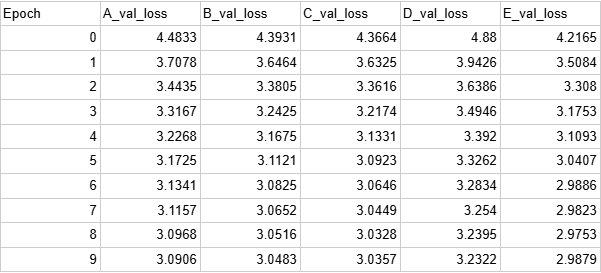

Figure 2 : Policy Accuracy through Epochs:

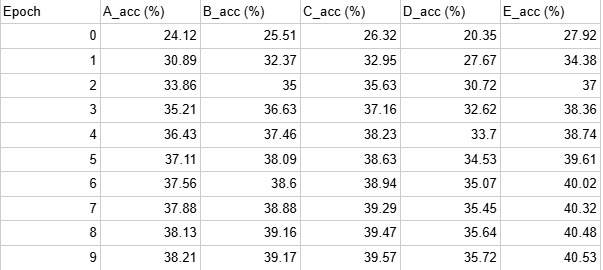

Figure 3 : Best Epoch for each model

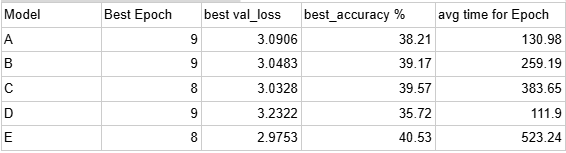

Figure 4 : Comparison to Stockfish

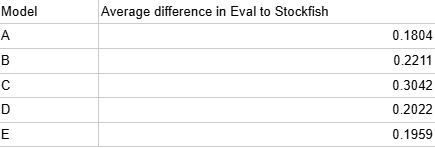

A simple visualization of these results shows:

Figure 5 : Validation loss per epoch

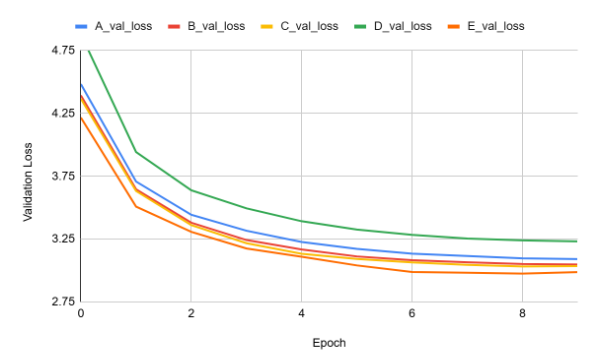

Figure 6 : Policy Accuracy per epoch

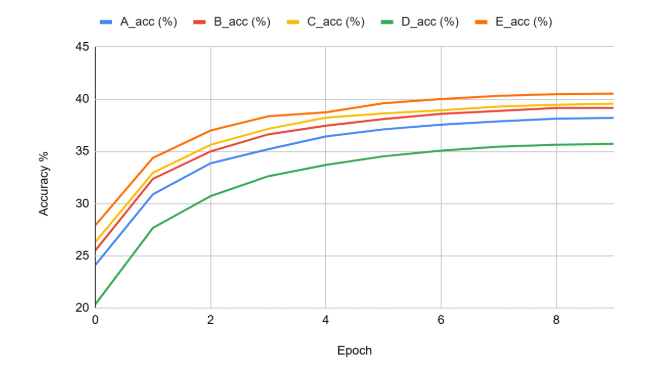


##4.4 Discussion:

The experiment revealed a clear trade off between model accuracy and generalization. Regarding Figure 1, the larger models such as model C and model E decreased their validation loss the most rapidly before reaching their peak at around 3.0328 and 2.9753 respectively at epoch 8. However for both of these models the validation loss rose at epoch 9, suggesting possible overfitting. In contrast, the smaller models (A and D) decreased validation loss more smoothly throughout the entire training cycle and didn’t reach a “peak” like the larger models did. This suggests that the models were learning relevant patterns of the data without overfitting. Regarding Figure 2, the larger models seemed to have a higher policy accuracy, which also suggests some level of overfitting. Instead of learning the “best move” from the final outcome of the game, the larger models seem to be memorizing the players’ moves from the dataset.

This trend is further reinforced by the results in Figure 3. The average rating difference in eval to stockfish increased between models A, B, and C (0.180->0.221->0.304). This suggests that the models with higher residual blocks were searching too deep for patterns which caused the model to start overfitting to the data, which caused the peak in validation loss as well as the poor stockfish performance. In contrast, adding filters to the model (B-> E) improved stockfish evaluation (0.221→0.196). Thus, adding residual blocks amplifies overfitting on our 100 K-game set, while adding filters enriches representation with less noise-memorization.


#5. Comparison


The key data from each model has been compiled into a table for easy comparison

Figure 7 : Model comparison

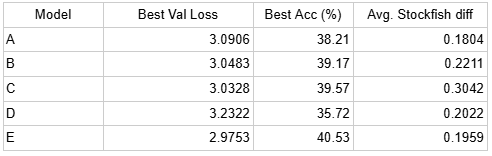

Comparing all models side by side shows that model E overall delivers the best sample metrics, with the lowest validation loss, best policy accuracy, followed closely by model C. However both of these models display poor stockfish alignment with a difference of 0.1959 and 0.3042 respectively. In contrast,model A has a slightly higher Validation loss and policy accuracy than these models, but stacks stockfish more closely with a difference of 0.1804. Model D also tracks stockfish well with a difference of 0.2022 despite its simpler architecture and lower validation loss/higher policy accuracy. Finally, model B seems to sit in the middle of all metrics, offering a balanced trade off between validation accuracy and stockfish alignment with a difference of 0.2022. Therefore deeper nets seem to do better in terms of raw accuracy but wider nets retain the best accuracy outside of its dataset.


#6. Conclusion


##6.1 Summary of Findings:

In regards to the research question, small architecture changes in a Convolutional Neural Network optimized for a specific task seem to dramatically affect model performance and accuracy. Deeper networks, which contain the most amount of residual blocks, have the best raw accuracy compared to its dataset, but more easily overfit to the data. In contrast, wider networks, which contain the most filters, have lower accuracy compared to its dataset, but have smoother training and are able to generalize patterns from the data more easily. These findings present a trade off between accuracy and generalization, whereas deeper models excel with accuracy and wider models excel at generalization.

##6.2 Implications

Architectural tuning must weigh available data. For use-cases where data is limited, it is advised to use shallower and wider networks to more easily generalize to future data. However, for use cases where data is abundant, it is advised to use deeper and more narrow networks to preserve accuracy to the data.

##6.3 Future works

Future research could involve scaling up training data to see to what extent architecture changes affect model performance at multiple different levels. Another possible area for exploration is to explore more hybrid architectures (for example moderate depth + wider blocks) to determine the absolute most effective model type for this use case. Finally, adding reinforcement learning to the system via self play and how performance/accuracy differs could provide valuable insights to the extent to which model architecture affects performance in other AI systems.

#7. Author Contributions

This was a solo project authored by Riley Seefeldt

#8. Data Availability

The source code for this project is listed at the github repo:
https://github.com/rileyseefeldt/ChessCNN
The data used for the project is available at the link:
https://database.lichess.org/

#References

jones, p. (2021). Chess Perft test positions. GitHub. Retrieved 4 27, 2025, from https://gist.github.com/peterellisjones/8c46c28141c162d1d8a0f0badbc9cff9

John Nickolls, Ian Buck, Michael Garland, Kevin Skadron Scalable Parallel Programming with CUDA ACM Queue, vol. 6 no. 2, March/April 2008, pp. 40-53

lichess. (2025). lichess.org open database. lichess. Retrieved April 25, 2025, from https://database.lichess.org/

Pascutto, Gian-Carlo and Linscott, Gary. (2019). Leela Chess Zero. Retrieved from http://lczero.org/

Romstad, T., Costalba, M., Kiiski, J., & Linscott, G. (2025). Stockfish. Stockfish - Strong open-source chess engine. Retrieved April 25, 2025, from https://stockfishchess.org/

Silver, D., Hubert, T., Schrittwieser, J., Antonoglou, I., Lai, M., Guez, A., Lanctot, M., Sifre, L., Kumaran, D., Graepel, T., Lillicrap, T., Simonyan, K., & Hassabis, D. (2017, December 5). [1712.01815] Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm. arXiv. Retrieved April 25, 2025, from https://arxiv.org/abs/1712.01815